In [1]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb

## データ修正

In [2]:
#データ読み込み
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [3]:
train.head()

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,...,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label
0,0,114501,58009,51,69.0,24.731460,0,1.0,Caucasian,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
1,1,44353,112590,19,64.0,28.666129,0,1.0,Caucasian,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
2,2,8023,1677,16,74.0,18.144869,0,0.0,Caucasian,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
3,3,106340,74166,188,60.0,23.047667,0,0.0,Caucasian,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
4,4,118467,52717,168,75.0,20.190265,0,0.0,Caucasian,F,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal,0


In [4]:
test.head()

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,...,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2
0,51359,12058,66446,83,37.0,NaN,0,0.0,Caucasian,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,51360,92348,32311,185,60.0,32.961764,1,0.0,Caucasian,M,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,51361,68371,20639,157,70.0,19.295957,0,1.0,Caucasian,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
3,51362,19544,116026,60,54.0,27.900747,0,1.0,Caucasian,M,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
4,51363,85588,102404,196,85.0,39.414062,0,1.0,Caucasian,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


In [5]:
pd.options.display.max_columns = 100
random_state = 123

In [6]:
#カテゴリと考えられる変数を変更
ids = ['id', 'personal_id_1', 'personal_id_2',]
# cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3']
# cats = ['facility_id', 'icu_5', 'icu_7', 'icu_8', 'icu_id', 'situation_1', 'situation_2', 'glasgow_coma_scale_3', 'blood_oxy'] old_cats
cats = ['facility_id', 'icu_5', 'icu_id'] #best_cats
dis_name = ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma'] 
for c in ids:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

for c in cats:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)
    
for c in dis_name:
    train[c] = train[c].astype(object)
    test[c] = test[c].astype(object)

In [7]:
# 数値データ
y_train=train[['target_label']]
x_train=train.drop('target_label',axis=1)
col_num = x_train.columns[x_train.dtypes!='object'].values.tolist()
print('数値データ')
print(col_num)
print('-'*100)
col_cat = x_train.columns[x_train.dtypes=='object'].values.tolist()
print('カテゴリ変数')
print(col_cat)

数値データ
['age', 'bmi', 'situation_1', 'situation_2', 'height', 'weight', 'icu_4', 'icu_6', 'icu_7', 'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
----------------------------------------------------------------------------------------------------
カテゴリ変数
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'ethnicity', 'gender', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma', 'body_system_1', 'body_system_

In [8]:
"""
エンコーディングの方針
nunique が比較的少ない変数はLabel Encoding
nunique が多い変数はCount EncodingとTarget Encodingの併用
"""

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in col_cat:
    nunq = x_train[c].nunique()
    if nunq>48:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)
        
body_systems = ['body_system_1', 'body_system_2']
for r in body_systems:
    low_cat_cols.remove(r)
        
print('-'*20, 'unique_low', '-'*20)
print(low_cat_cols)
print('-'*20, 'unique_high', '-'*20)
print(high_cat_cols)

print('-'*20, 'body_systems', '-'*20)
print(body_systems)

-------------------- unique_low --------------------
['ethnicity', 'gender', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']
-------------------- unique_high --------------------
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'icu_id']
-------------------- body_systems --------------------
['body_system_1', 'body_system_2']


In [9]:
#少ない要素は確認してみる
for c in low_cat_cols:
    print(f"{c}:\t{x_train[c].unique()}")

ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_5:	[302.0 nan 304.0 123.0 114.0 305.0 301.0 122.0 119.0 308.0 113.0 118.0
 124.0 104.0 303.0 112.0 109.0 117.0 209.0 214.0 121.0 202.0 212.0 110.0
 101.0 116.0 217.0 102.0 115.0 203.0 105.0 103.0 108.0 307.0 213.0 120.0
 106.0 216.0 306.0 107.0 207.0 215.0 218.0 219.0 208.0]
aids:	[0.0 nan 1.0]
cirrhosis:	[0.0 1.0 nan]
diabetes:	[1.0 0.0 nan]
hepatic_issue:	[0.0 1.0 nan]
immunosuppression:	[0.0 1.0 nan]
leukemia:	[0.0 1.0 nan]
lymphoma:	[0.0 nan 1.0]
carcinoma:	[0.0 1.0 nan]


In [10]:
#nunique が少ない変数はLabel Encoding
#body_system1,2は同様のカラムだと考えohe

dict_low_cat = {}
for col in low_cat_cols:
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(x_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    # print(list_label)
    map_label = {j:i for i,j in enumerate(list_label)}
    x_train[col] = x_train[col].map(map_label)
    
    dict_low_cat[col] = {}
    dict_low_cat[col]['fillna'] = value_fillna
    dict_low_cat[col]['map_label'] = map_label
    dict_low_cat[col]['num_label'] = len(list_label)

print('Done')

ethnicity
gender
icu_1
icu_2
icu_3
icu_5
aids
cirrhosis
diabetes
hepatic_issue
immunosuppression
leukemia
lymphoma
carcinoma
Done


In [11]:
# nunique が多い変数はCount EncodingとTarget Encodingの併用
# クロスバリデーション内で行う

# Count Encoding用
ids = ['id', 'personal_id_1', 'personal_id_2']
for i in ids:
    high_cat_cols.remove(i)
    
dict_high_cat = {}
for col in high_cat_cols :
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    
    map_count = x_train[col].value_counts().to_dict()
    x_train['CE_' + col] = x_train[col].map(map_count)
    
    dict_high_cat[col] = {}
    dict_high_cat[col]['fillna'] = value_fillna
    dict_high_cat[col]['map_count'] = map_count
    # dict_high_cat[col]['num_label'] = len(list_label)
    
    
print('Done')

facility_id
icu_id
Done


In [12]:
# 数値データは標準化
dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    x_train[col] = x_train[col].fillna(value_fillna)
    # 正規化
    value_min = x_train[col].min()
    value_max = x_train[col].max()
    value_mean = x_train[col].mean()
    value_std = x_train[col].std()
    #train[col] = (train[col] - value_min) / (value_max - value_min)
    x_train[col] = (x_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_mean    
    dict_num[col]['std'] = value_std    
    
print('Done')

age
bmi
situation_1
situation_2
height
weight
icu_4
icu_6
icu_7
icu_8
glasgow_coma_scale_1
glasgow_coma_scale_2
glasgow_coma_scale_3
glasgow_coma_scale_4
heart_rate
blood_oxy
arterial_pressure
respiratory_rate
temp
blood_pressure_1
blood_pressure_2
blood_pressure_3
blood_pressure_4
v1_heartrate_max
v2
v3
v4
v5
v6
v7
v8
v9
v10
v11
v12
v13
v14
v15
v16
w1
w2
w3
w4
w5
w6
w7
w8
w9
w10
w11
w12
w13
w14
w15
w16
w17
w18
x1
x2
x3
x4
x5
x6
Done


In [13]:
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        value_mean = dict_num[col]['mean']
        value_std = dict_num[col]['std']
        
        # output_x[col]  = (output_x[col] - value_min ) / (value_max - value_min)
        output_x[col]  = (output_x[col] - value_mean ) / (value_std)
        
        
    for col in low_cat_cols:
        value_fillna = dict_low_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_low_cat[col]['map_label']#辞書からlabel_encordの辞書を取り出す
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    for col in high_cat_cols:
        value_fillna = dict_high_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_count = dict_high_cat[col]['map_count']#辞書からcount_encodの辞書を取り出す
        output_x['CE_' + col] = output_x[col].map(map_count)
        
        
    return output_x

x_test = transform_data(test)

In [14]:
#body_sytemsとhigh_cat_cols（target_encord)以外修正後
#データを統合しbody_sytemsをone_hotencoding

# OHEのため全データ合算
concat_df = pd.concat([x_train, x_test], sort=False, ignore_index = True)

#病名のみのdf
train_body=concat_df[['body_system_1','body_system_2']]
#被っているものはbody_system_2をNanに
train_body['body_system_2'] = train_body['body_system_2'].where(
    train_body['body_system_1'] != train_body['body_system_2'])
#Nanはunknoun
train_body.fillna('unknown', inplace=True)

train_body['body_system_2'] = train_body['body_system_2'].replace('Undefined diagnoses', 'Undefined Diagnoses')
print(train_body.shape, concat_df.shape)

print(train_body['body_system_1'].unique())
print(train_body['body_system_2'].unique())
# ohe実行
ohe_body = pd.get_dummies(train_body.stack(), dummy_na=False, prefix='ohe').groupby(level=0).sum()

(64199, 2) (64199, 86)
['Cardiovascular' 'unknown' 'Gastrointestinal' 'Metabolic' 'Genitourinary'
 'Neurological' 'Trauma' 'Sepsis' 'Respiratory' 'Musculoskeletal/Skin'
 'Gynecological' 'Hematological']
['unknown' 'Renal/Genitourinary' 'Neurologic' 'Undefined Diagnoses'
 'Cardiovascular' 'Haematologic']


In [15]:
ohe_concat_df = pd.concat([concat_df, ohe_body], axis=1)#元の全体のDFに病歴のOHEをつなげる
ohe_concat_df = ohe_concat_df.drop(['body_system_1','body_system_2','ohe_unknown'], axis=1)
# 学習とテストに分解
x_train = ohe_concat_df[:len(x_train)]
x_test = ohe_concat_df[len(x_train):].reset_index(drop=True)

# idを別のdfに、
id_train = x_train[['id']]
x_train = x_train.drop(['id'], axis=1)

id_test = x_test[id_train.columns]
x_test = x_test.drop(['id'], axis=1)

print('学習用データ: {},   学習ラベル：{},  テストデータ：{}、学習IDデータ:{}, テストIDデータ:{}'.format(
    x_train.shape, y_train.shape, x_test.shape, id_train.shape, id_test.shape))
# print('taget_encord用学習データ：{},  target_encord用テストデータ：{}'.format(
#       te_base_train.shape, te_base_test.shape))

print('陽性ラベルの割合: {}'.format(
    y_train.value_counts()[1]  / len(train)))

学習用データ: (51359, 98),   学習ラベル：(51359, 1),  テストデータ：(12840, 98)、学習IDデータ:(51359, 1), テストIDデータ:(12840, 1)
陽性ラベルの割合: 0.08629451508012227


In [16]:
#初期データ
display(train)
display(test)

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label
0,0,114501,58009,51,69.0,24.731460,0,1.0,Caucasian,M,175.30,76.0,698,Floor,admit,MICU,25.801389,302.0,109.09,0,0.0,3.0,6.0,0.0,3.0,100.0,0.0,50.0,33.0,NaN,59.0,46.0,59.0,46.0,96.0,91.0,84.0,53.0,84.0,53.0,16.0,14.0,100.0,97.0,124.0,67.0,124.0,67.0,37.10,36.80,46.0,46.0,46.0,46.0,96.0,96.0,53.0,53.0,53.0,53.0,16.0,16.0,100.0,100.0,75.0,67.0,75.0,67.0,243.0,76.0,3.5,3.5,0.25,0.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
1,1,44353,112590,19,64.0,28.666129,0,1.0,Caucasian,M,183.00,96.0,657,Floor,admit,CCU-CTICU,3.639583,NaN,0.19,0,0.0,1.0,1.0,0.0,1.0,117.0,0.0,145.0,4.0,36.72,73.0,48.0,73.0,48.0,111.0,62.0,100.0,59.0,100.0,59.0,30.0,0.0,97.0,87.0,178.0,99.0,178.0,99.0,37.38,36.72,NaN,NaN,NaN,NaN,83.0,80.0,NaN,NaN,NaN,NaN,17.0,8.0,94.0,93.0,NaN,NaN,NaN,NaN,158.0,109.0,4.2,4.2,0.42,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
2,2,8023,1677,16,74.0,18.144869,0,0.0,Caucasian,F,166.00,50.0,482,Accident & Emergency,admit,MICU,0.059028,304.0,307.01,0,0.0,4.0,6.0,0.0,5.0,53.0,0.0,50.0,6.0,36.10,65.0,39.0,65.0,39.0,71.0,55.0,73.0,50.0,73.0,50.0,18.0,11.0,100.0,100.0,122.0,69.0,122.0,69.0,37.00,36.10,65.0,65.0,65.0,65.0,62.0,59.0,73.0,73.0,73.0,73.0,18.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,62.0,4.2,4.1,0.07,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
3,3,106340,74166,188,60.0,23.047667,0,0.0,Caucasian,M,182.90,77.1,855,Accident & Emergency,admit,CCU-CTICU,0.014583,123.0,702.01,0,0.0,4.0,6.0,0.0,5.0,102.0,0.0,127.0,4.0,37.00,87.0,69.0,87.0,69.0,99.0,75.0,114.0,86.0,114.0,86.0,21.0,15.0,100.0,96.0,153.0,123.0,153.0,123.0,37.10,36.60,80.0,73.0,80.0,73.0,99.0,96.0,97.0,86.0,97.0,86.0,18.0,17.0,98.0,97.0,124.0,123.0,124.0,123.0,373.0,46.0,4.2,3.2,0.01,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
4,4,118467,52717,168,75.0,20.190265,0,0.0,Caucasian,F,160.02,51.7,136,Accident & Emergency,admit,Med-Surg ICU,0.004861,304.0,308.01,0,0.0,4.0,6.0,0.0,5.0,90.0,0.0,68.0,28.0,36.80,87.0,87.0,87.0,87.0,90.0,90.0,105.0,105.0,105.0,105.0,14.0,11.0,97.0,92.0,147.0,147.0,147.0,147.0,36.80,36.80,100.0,56.0,100.0,56.0,67.0,61.0,104.0,68.0,104.0,68.0,28.0,24.0,94.0,90.0,142.0,114.0,142.0,114.0,NaN,NaN,NaN,NaN,0.08,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51354,51354,88819,81966,64,67.0,20.622289,1,0.0,Caucasian,F,142.20,41.7,683,Operating Room / Recovery,admit,Med-Surg ICU,1.352778,304.0,1409.01,1,0.0,4.0,6.0,0.0,5.0,132.0,0.0,66.0,34.0,36.80,70.0,56.0,70.0,56.0,128.0,90.0,87.0,65.0,87.0,65.0,29.0,22.0,100.0,96.0,101.0,82.0,101.0,82.0,37.00,36.80,59.0,59.0,59.0,59.0,128.0,128.0,67.0,67.0,67.0,67.0,22.0,22.0,100.0,100.0,82.0,82.0,82.0,82.0,152.0,134.0,4.4,4.1,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
51355,51355,45825,3470,161,63.0,35.054523,0,0.0,Caucasian,M,175.20,107.6,413,Accident & Emergency,admit,Med-Surg ICU,0.005556,113.0,501.02,0,0.0,4.0,6.0,0.0,4.0,165.0,0.0,48.0,34.0,36.60,81.0,41.0,81.0,41.0,162.0,78.0,91.0,54.0,91.0,54.0,34.0,10.0,100

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2
0,51359,12058,66446,83,37.0,NaN,0,0.0,Caucasian,M,182.9,NaN,95,Floor,readmit,Med-Surg ICU,0.902778,113.0,501.02,0,0.0,4.0,6.0,0.0,5.0,123.0,0.0,76.0,4.0,37.00,74.0,56.0,74.0,56.0,120.0,103.0,93.0,74.0,93.0,74.0,19.0,6.0,99.0,90.0,127.0,106.0,127.0,106.0,37.30,36.90,65.0,60.0,65.0,60.0,112.0,104.0,84.0,84.0,84.0,84.0,19.0,16.0,99.0,92.0,115.0,111.0,115.0,111.0,160.0,122.0,3.5,3.5,-1.00,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,51360,92348,32311,185,60.0,32.961764,1,0.0,Caucasian,M,185.4,113.30,679,Operating Room / Recovery,admit,Neuro ICU,0.406944,NaN,0.25,0,0.0,3.0,6.0,0.0,4.0,60.0,0.0,151.0,5.0,37.20,85.0,81.0,85.0,81.0,83.0,68.0,132.0,107.0,132.0,107.0,14.0,11.0,97.0,92.0,191.0,146.0,191.0,146.0,37.40,37.20,85.0,85.0,85.0,85.0,68.0,68.0,132.0,132.0,132.0,132.0,11.0,11.0,97.0,97.0,191.0,191.0,191.0,191.0,259.0,184.0,4.4,4.4,0.05,0.01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,51361,68371,20639,157,70.0,19.295957,0,1.0,Caucasian,M,177.8,61.00,697,Floor,admit,SICU,0.977083,303.0,211.09,0,0.0,3.0,5.0,0.0,1.0,106.0,0.0,58.0,39.0,36.50,78.0,51.0,78.0,51.0,87.0,69.0,98.0,73.0,98.0,73.0,20.0,14.0,100.0,100.0,127.0,103.0,127.0,103.0,36.60,36.50,78.0,78.0,78.0,78.0,87.0,87.0,98.0,98.0,98.0,98.0,14.0,14.0,100.0,100.0,127.0,127.0,127.0,127.0,113.0,93.0,4.1,4.1,0.13,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
3,51362,19544,116026,60,54.0,27.900747,0,1.0,Caucasian,M,180.3,90.70,538,Accident & Emergency,admit,Med-Surg ICU,0.172917,122.0,703.03,0,0.0,4.0,6.0,0.0,4.0,118.0,0.0,189.0,53.0,NaN,144.0,73.0,144.0,73.0,118.0,59.0,184.0,81.0,181.0,81.0,53.0,0.0,100.0,94.0,232.0,101.0,232.0,101.0,35.10,34.50,112.0,95.0,112.0,95.0,102.0,88.0,136.0,116.0,136.0,116.0,29.0,15.0,98.0,97.0,183.0,156.0,183.0,156.0,101.0,101.0,3.7,3.7,0.03,0.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
4,51363,85588,102404,196,85.0,39.414062,0,1.0,Caucasian,F,160.0,100.90,809,Accident & Emergency,admit,CSICU,0.031944,117.0,106.01,0,0.0,4.0,6.0,0.0,5.0,165.0,0.0,63.0,37.0,36.70,84.0,52.0,84.0,52.0,163.0,114.0,91.0,63.0,91.0,63.0,32.0,18.0,98.0,89.0,119.0,90.0,119.0,90.0,37.10,36.70,66.0,66.0,66.0,66.0,160.0,144.0,77.0,77.0,77.0,77.0,27.0,27.0,96.0,96.0,119.0,119.0,119.0,119.0,110.0,110.0,3.9,3.9,0.15,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12835,64194,79880,56511,19,39.0,23.147277,0,0.0,Caucasian,F,163.0,61.50,657,Accident & Emergency,admit,CCU-CTICU,0.155556,304.0,301.01,0,0.0,4.0,6.0,0.0,5.0,113.0,0.0,62.0,8.0,36.33,98.0,52.0,98.0,52.0,111.0,84.0,106.0,62.0,106.0,62.0,21.0,10.0,97.0,88.0,159.0,85.0,159.0,85.0,37.38,36.33,63.0,54.0,63.0,54.0,103.0,100.0,75.0,68.0,75.0,68.0,17.0,15.0,94.0,90.0,120.0,109.0,120.0,109.0,117.0,89.0,6.4,5.5,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
12836,64195,97405,32055,136,79.0,27.759515,0,0.0,Caucasian,M,175.5,85.50,374,Accident & Emergency,admit,Med-Surg ICU,0.195139,112.0,107.01,0,0.0,4.0,6.0,0.0,5.0,103.0,0.0,46.0,13.0,36.30,77.0,43.0,77.0,43.0,99.0,69.0,82.0,51.0,82.0,51.0,19.

In [17]:
# 処理後
display(x_train)
display(x_test)

,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,114501,58009,51,0.454939,-0.346609,-0.471832,1.443232,2,1,0.357984,-0.195864,698,1,0,4,9.824534,37,-0.950656,-0.499575,-0.169112,-0.364472,0.431568,-0.09965,-0.551220,0.041533,-0.421879,-0.867503,0.491333,-4.578308,-1.455805,-0.299609,-1.309907,-0.254255,-0.303307,1.202584,-0.952377,-0.732021,-0.779641,-0.621162,-1.173673,0.229275,0.181114,0.601904,-0.910726,-1.414643,-0.750488,-1.256699,0.128090,0.251801,-1.135559,-0.712502,-0.871348,-0.521734,0.247360,0.604711,-1.198436,-0.877398,-0.875818,-0.624948,-0.632524,-0.060750,0.310772,0.438751,-1.419156,-1.302980,-1.055307,-0.987881,0.846082,-0.674140,-0.209287,-0.016758,0.717065,0.144185,0,0,1,0,0,0,0,0,59,59.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,44353,112590,19,0.216694,0.055736,-0.471832,1.443232,2,1,0.699250,0.508950,657,1,0,0,1.103269,44,-1.185370,-0.499575,-0.169112,-2.238334,-2.885738,-0.09965,-1.764683,0.568969,-0.421879,1.348143,-1.401226,0.256231,-0.760407,-0.151944,-0.668262,-0.115033,0.367228,-0.477670,-0.205836,-0.357263,-0.121707,-0.279873,0.112386,-2.497529,-0.302122,-0.277496,1.132586,0.106505,1.047114,0.135313,0.175810,0.237807,-3.113997,-2.992253,-2.560925,-2.491330,-0.239682,-0.044994,-3.066399,-2.953012,-2.448796,-2.386595,-0.518908,-1.204625,0.020188,0.103285,-3.426503,-3.250548,-2.727143,-2.634298,-0.058791,0.040596,0.275211,0.511727,1.428209,1.005841,0,0,0,0,0,0,0,0,2227,465.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8023,1677,16,0.693185,-1.020130,-0.471832,-0.692876,2,0,-0.054194,-1.112121,482,0,0,4,-0.305776,39,-0.524075,-0.499575,-0.169112,0.572458,0.431568,-0.09965,0.662243,-1.416674,-0.421879,-0.867503,-1.270705,0.174602,-1.157777,-0.816439,-1.034917,-0.741531,-1.420866,-0.883248,-1.465624,-0.919400,-1.231970,-0.791807,-0.989951,-0.355040,0.181114,0.865724,-0.986404,-1.319571,-0.817066,-1.169699,0.111047,0.129353,-0.318379,0.229135,-0.173479,0.291794,-1.026441,-0.897732,-0.493545,-0.094147,-0.282242,0.039824,-0.405292,-0.489703,0.310772,0.438751,-0.750040,-0.343730,-0.498029,-0.176960,-0.963663,-0.977362,0.275211,0.436229,-0.035911,-0.047294,0,0,0,0,0,0,0,0,142,142.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,106340,74166,188,0.026097,-0.518788,-0.471832,-0.692876,2,1,0.694818,-0.157099,855,0,0,0,-0.323266,21,0.327276,-0.499575,-0.169112,0.572458,0.431568,-0.09965,0.662243,0.103584,-0.421879,0.928337,-1.401226,0.293095,-0.065009,1.398544,-0.026617,1.346798,-0.169200,0.275548,0.447387,1.329149,0.453985,1.255928,-0.714366,0.424046,0.181114,0.513964,0.186608,1.247367,0.214891,1.179323,0.128090,0.216816,0.326764,0.625613,0.377470,0.634333,0.359754,0.604711,0.352325,0.414965,0.430050,0.471927,-0.405292,0.082234,0.213911,0.294980,-0.107689,0.324838,0.036959,0.388228,2.230005,-1.323900,0.275211,-0.243252,-0.286903,-0.190903,0,0,1,0,0,0,0,0,1751,491.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,118467,52717,168,0.740834,-0.810975,-0.471832,-0.692876,2,0,-0.319229,-1.052212,136,0,0,5,-0.327092,39,-0.521920,-0.499575,-0.169112,0.572458,0.431568,-0.09965,0.662243,-0.268724,-0.421879,-0.447696,0.165030,0.266763,-0.065009,2.727534,-0.026617,2.599796,-0.571521,1.144644,0.027458,2.515883,0.083897,2.336676,-1.357396,-0.3

,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,12058,66446,83,-1.069832,-2.875558,-0.471832,-0.692876,2,1,0.694818,-2.874154,95,1,1,5,0.026262,11,-0.105922,-0.499575,-0.169112,0.572458,0.431568,-0.09965,0.662243,0.755123,-0.421879,-0.261115,-1.401226,0.293095,-0.710736,0.438718,-0.622430,0.441855,0.769549,1.897861,-0.532448,0.579633,-0.409553,0.573349,-0.898089,-1.328899,0.020035,-0.013676,-0.797209,0.439256,-0.650621,0.439816,0.162176,0.269294,-0.318379,-0.018664,-0.173479,0.077708,0.846795,0.929564,-0.105855,0.336640,0.044225,0.405449,-0.291676,-0.060750,0.262341,0.055362,-0.348571,-0.023980,-0.163662,0.093347,-0.037499,0.322158,-0.209287,-0.016758,-4.511935,-0.047294,0,0,0,0,0,0,0,0,451,451.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,92348,32311,185,0.026097,0.494992,2.119358,-0.692876,2,1,0.805619,1.118613,679,2,0,6,-0.168861,44,-1.185241,-0.499575,-0.169112,-0.364472,0.431568,-0.09965,0.055512,-1.199494,-0.421879,1.488079,-1.335965,0.319427,-0.164352,2.284537,-0.118281,2.182130,-0.884438,-0.130031,1.287246,2.640803,1.194161,2.450439,-1.357396,-0.355040,-0.302122,0.162204,1.624494,2.340692,1.479870,2.179832,0.179219,0.321772,0.541811,1.220331,0.561119,1.148140,-0.801653,-0.532273,1.585885,2.216441,1.468808,2.000903,-1.200605,-0.775672,0.165480,0.294980,1.685541,2.301474,1.530465,2.059217,1.016411,1.664995,0.413639,0.662723,-0.119575,-0.143033,0,0,1,0,0,0,0,0,1000,136.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,68371,20639,157,0.502588,-0.902424,-0.471832,1.443232,2,1,0.468785,-0.724474,697,1,0,7,0.055504,38,-0.730814,-0.499575,-0.169112,-0.364472,-0.231893,-0.09965,-1.764683,0.227687,-0.421879,-0.680922,0.882897,0.227266,-0.512051,0.069555,-0.439103,0.093800,-0.705628,-0.072091,-0.299154,0.517173,-0.203949,0.516468,-0.806228,0.229275,0.181114,0.865724,-0.797209,0.296649,-0.650621,0.309315,0.042875,0.199324,0.240745,0.873412,0.304010,0.848419,-0.089823,0.239252,0.387570,0.884916,0.459728,0.870790,-0.859757,-0.346719,0.310772,0.438751,-0.027395,0.441111,0.103832,0.486521,-0.537841,-0.305943,0.205997,0.436229,0.215081,0.096315,0,0,0,0,0,0,0,0,751,350.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,19544,116026,60,-0.259798,-0.022529,-0.471832,1.443232,2,1,0.579586,0.322174,538,0,0,5,-0.260957,20,0.329474,-0.499575,-0.169112,0.572458,0.431568,-0.09965,0.055512,0.599995,-0.421879,2.374337,1.796546,-4.578308,2.766253,1.693875,2.585796,1.625242,0.680144,-0.651489,3.713504,1.016850,3.209083,0.971520,2.225197,-2.497529,0.181114,0.338084,3.175898,0.201577,2.844715,0.222314,-0.212768,-0.150528,1.703068,1.715929,1.552828,1.576313,0.472148,0.279859,1.726863,1.589841,1.587523,1.469085,0.844486,-0.203734,0.213911,0.294980,1.471424,1.284088,1.352136,1.199149,-0.665587,-0.132674,-0.070859,0.134238,-0.203239,-0.095163,0,0,1,0,0,0,0,0,320,320.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,85588,102404,196,1.217325,1.154780,-0.471832,1.443232,2,0,-0.320116,0.681629,809,0,0,1,-0.316434,15,-0.957295,-0.499575,-0.169112,0.572458,0.431568,-0.09965,0.662243,2.058201,-0.421879,-0.564309,0.752376,0.253597,-0.214023,0.143387,-0.164112,0.163411,2.691749,2.535199,-0.625765,-0.107424,-0.491795,-0.052347,0.296108,1.008361,-0.141044,-0.101616,-1.099922,-0.321318,-

In [18]:
# テストデータをtargetencording
def tranform_data_TE(cat_cols, input_x, train_label):#catslist, testdata(df), labels(series) =>df
    output_x = input_x.copy()
    
    for c in cat_cols :
        data_tmp = pd.DataFrame({c: output_x[c], 'target': train_label})
        target_mean = data_tmp.groupby(c)['target'].mean()
        output_x.loc[:, c] = output_x[c].map(target_mean)
        
    return  output_x

# target_encordするカテゴリ変数を指定
cat_cols = ['facility_id', 'icu_id']
x_test = tranform_data_TE(cat_cols, x_test, y_train['target_label'])

In [19]:
# 学習データをtargetencordingする関数、実際にはCV内で実行
def target_encoding(cat_cols, tr_x, tr_y, va_x):#list_cat df*3 => df*2
    # クロスバリデーションの中で実行し、出力されたデータでモデル学習する
    for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: tr_x[c], 'target': tr_y['target_label']})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # バリデーションデータのカテゴリを置換
        va_x.loc[:, c] = va_x[c].map(target_mean)

        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, tr_x.shape[0])
        
        cv_encoding = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(tr_x,tr_y['target_label']))
        for  nfold in list_nfold:
            idx_1, idx_2 = cv_encoding[nfold][0], cv_encoding[nfold][1]
            # out-of-foldで各カテゴリにおける目的変数の平均を計算
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            # 変換後の値を一時配列に格納
            tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)
        
        tr_x.loc[:, c] = tmp
        
    return tr_x, va_x

##　確認用重み調整（実際はholdごとに）

In [20]:
from sklearn.utils.class_weight import compute_sample_weight
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
train_weight[:30]

array([0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       5.794111  , 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 5.794111  , 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 5.794111  , 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226,
       0.54722226, 0.54722226, 0.54722226, 0.54722226, 0.54722226],
      dtype=float32)

In [21]:
# カテゴリカル変数（ラベルエンコードとワンホットエンコードした特徴量）
# low_cat_colsは0,1、idsは三つのID、そのほかはOHEの出力0,1
cat_feats = low_cat_cols + [c for c in x_train.columns if c.startswith('ohe_')] + ['personal_id_1','personal_id_2']
for cat in cat_feats:
    # Category型に変換
    x_train[cat] = x_train[cat].astype('category')
    x_test[cat] = x_test[cat].astype('category')   
    
N_FOLDS = 5
list_nfold=[0,1,2,3,4]
oof = np.zeros(len(x_train))
pred = np.zeros(len(x_test))
fi_df = pd.DataFrame()

# 必要に応じてencodeされた特徴量を保存し、あとで読み込めるようにしておく

# LightGBMのモデルの定義
random_state = 123
params = {
   'objective': 'binary:logistic',    # 2値分類の格率値をreturn
    'eval_metric' : 'auc', 
    'learning_rate': 0.02,
    'eta': 0.3,                  # 大きいほど、過学習より　（range = 0〜）
    'max_depth': 9,              # 大きいほど、過学習より　（range = 0〜）
    'min_child_weight': 1,       # 小さいほど、過学習より　 （range = 0〜）
    'gamma': 0,                  # 小さいほど、過学習より　 （range = 0〜）
    'colsample_bytree': 1.0, 
    'subsample': 1.0,            # 大きいほど、過学習へ （range = 0〜1）
    'alpha': 0,                  # 小さいほど、過学習へ　（range = 0〜）
    'lambda': 0.1,               # 小さいほど、過学習へ （range = 0〜）
    'random_state' : 123
    }


In [79]:
# cvでの評価用 iuput_yはsereis
def train_xg(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
    print(input_x.shape)
    print(input_y.shape)
    
            
    cv = list(StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(input_x, input_y ))
    for  nfold in list_nfold :
        print('-'*20, nfold, '-'*20)
        # 変数をループしてtarget encoding
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        #CV内でCVしてtargetencording
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        
        # XGBoosting用のデータセットを生成
        d_x_tr = xgb.DMatrix(x_tr, label=y_tr, enable_categorical=True, feature_names = x_tr.columns)
        d_x_va = xgb.DMatrix(x_va, label=y_va, enable_categorical=True, feature_names = x_va.columns) 
        # watchリスト
        watchlist = [(d_x_tr, 'train'), (d_x_va, 'eval')]
        # XGBoostモデル・オブジェクトの生成
        results_dict = {}


        
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
        
        # print(x_tr)
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
          format(y_train['target_label'].mean(), y_tr['target_label'].mean(), y_va['target_label'].mean(),))


        model = xgb.train(
                params, 
                d_x_tr,
                num_boost_round = 100000, 
                early_stopping_rounds = 100,        # Early-stopping の 忍耐数を設定。　　50〜100で十分なケースが多い
                evals_result = results_dict, 
                evals = watchlist, 
                verbose_eval=100,
                 )
        
        # モデルの保存
        fname_xgb = 'model/xgb/model_xgb_fold{}.pickle'.format(nfold)
        with open(fname_xgb, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict(d_x_tr, iteration_range=(0, model.best_iteration + 1))
        y_va_pred = model.predict(d_x_va, iteration_range=(0, model.best_iteration + 1))
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        print('[auc] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        imp_dict = model.get_score(importance_type='gain')
        _imp = pd.DataFrame.from_dict(imp_dict, orient='index', columns=['imp']).reset_index()
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)
    

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        roc_auc_score(input_y, train_oof)))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('index')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [74]:
train_oof, imp, metrics = train_xg(x_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

(51359, 98)
(51359, 1)
-------------------- 0 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.88270	eval-auc:0.83371
[61]	train-auc:0.94830	eval-auc:0.88458
[auc] tr: 0.94, va: 0.885061
-------------------- 1 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.88833	eval-auc:0.82824
[100]	train-auc:0.96541	eval-auc:0.87180
[200]	train-auc:0.99305	eval-auc:0.87710
[300]	train-auc:0.99849	eval-auc:0.88199
[394]	train-auc:0.99927	eval-auc:0.88384
[auc] tr: 1.00, va: 0.883901
-------------------- 2 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.89507	eval-auc:0.83725
[66]	train-auc:0.95160	eval-auc:0.87360
[auc] tr: 0.95, va: 0.873728
-------------------- 3 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[0]	train-auc:0.88918

In [78]:
imp.sort_values('imp', ascending=False)[:20]

,col,imp_mean,imp_std
0,CE_facility_id,4.882144,0.943129
1,CE_icu_id,4.561597,0.582076
2,age,4.652831,0.484946
3,arterial_pressure,4.903860,0.720345
4,blood_oxy,5.243767,0.689195
...,...,...,...
88,x2,5.481736,0.800823
89,x3,5.581561,0.998592
90,x4,5.411734,0.957083
91,x5,72.527882,23.408558


In [70]:
# 説明変数の重要度を整形
imp = imp.groupby('index')['importance'].agg(['mean', 'std'])

,index,imp
0,personal_id_1,4.456946
1,personal_id_2,4.640925
2,facility_id,5.402775
3,age,4.621734
4,bmi,5.479610
...,...,...
84,ohe_Musculoskeletal/Skin,3.198660
85,ohe_Neurologic,4.955086
86,ohe_Respiratory,4.744227
87,ohe_Sepsis,2.591197


In [253]:
imp.sort_values('imp', ascending=False)[:20]

,col,imp,imp_std
27,icu_4,2316.4,468.638773
28,icu_5,2216.4,314.389567
65,v2,2156.6,356.735616
2,age,2055.4,320.398658
93,x2,2024.2,361.301398
15,facility_id,1923.4,340.935918
92,x1,1878.8,374.803549
96,x5,1872.4,262.707632
32,icu_id,1806.0,381.518676
10,bmi,1785.2,330.772883


In [254]:
display(train_oof)

,id,pred
0,0,0.351791
1,1,0.335922
2,2,0.037295
3,3,0.000943
4,4,0.039220
...,...,...
51354,51354,0.042559
51355,51355,0.201149
51356,51356,0.104583
51357,51357,0.004105


## 推論

In [255]:
def predict_lgb(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'target_label':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [256]:
test_pred_proba = predict_lgb(
    x_test,
    id_test,
    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [257]:
test_pred_proba.to_csv('sub/submission_cat-pid+.csv', index=None, header=True,)

In [258]:
sample= pd.read_csv("data/submission.csv")

## ベースライン

In [22]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (41087, 98) (41087, 1)
ベースライン検証データ:  (10272, 98) (10272, 1)
検証データ(train):  (32869, 98) (32869, 1)
検証データ(test):  (8218, 98) (8218, 1)


In [30]:
cat_cols = ['facility_id', 'icu_id']
x_tr1, x_va1 = target_encoding(cat_cols, x_tr1, y_tr1, x_va1)
x_va1 = tranform_data_TE(cat_cols, x_va1, y_tr1['target_label'])
x_va2 = tranform_data_TE(cat_cols, x_va2, y_tr['target_label'])

In [34]:
# XGBoosting用のデータセットを生成
d_x_tr1 = xgb.DMatrix(x_tr1, label=y_tr1, enable_categorical=True, feature_names = x_tr1.columns)
d_x_va1 = xgb.DMatrix(x_va1, label=y_va1, enable_categorical=True, feature_names = x_va1.columns) 
d_x_va2 = xgb.DMatrix(x_va2, label=y_va2, enable_categorical=True, feature_names = x_va2.columns) 

# watchリスト
watchlist = [(d_x_tr1, 'train'), (d_x_va1, 'eval')]
# XGBoostモデル・オブジェクトの生成
results_dict = {}


model = xgb.train(
            params, 
            d_x_tr1,
            num_boost_round = 100000, 
            early_stopping_rounds = 100,        # Early-stopping の 忍耐数を設定。　　50〜100で十分なケースが多い
            evals_result = results_dict, 
            evals = watchlist, 
            verbose_eval=100,
             )

[0]	train-auc:0.88536	eval-auc:0.83628
[100]	train-auc:0.97250	eval-auc:0.88329
[200]	train-auc:0.99547	eval-auc:0.88547
[300]	train-auc:0.99932	eval-auc:0.88867
[400]	train-auc:0.99983	eval-auc:0.88984
[476]	train-auc:0.99995	eval-auc:0.88959


In [60]:
imp_dict = model.get_score(importance_type='gain')
temp_df = pd.DataFrame.from_dict(imp_dict, orient='index', columns=['imp']).reset_index()
temp_df.sort_values('index', ascending=False)[:10]

,index,imp
71,x6,34.032425
70,x5,24.341492
69,x4,3.562681
68,x3,3.598368
67,x2,3.372906
66,x1,3.167221
10,weight,3.216550
56,w9,2.730711
55,w8,2.992070
54,w7,3.223911


In [37]:
#評価指標の差
y_va1_pred = model.predict(d_x_va1, iteration_range=(0, model.best_iteration + 1))
y_va2_pred = model.predict(d_x_va2, iteration_range=(0, model.best_iteration + 1))

print('[検証データ] auc: {:.4f}'.format(roc_auc_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] auc: {:.4f}'.format(roc_auc_score(y_va2, y_va2_pred)))

# ax = lgb.plot_metric(model.evals_result_, metric='auc', figsize=(5, 3))

[検証データ] auc: 0.8899
[ベースライン検証データ] auc: 0.8883


In [54]:
#誤分類の分布
print('検証データ')
print(confusion_matrix(y_va1, np.where(y_va1_pred>0.5,1,0)))
print(confusion_matrix(y_va1, np.where(y_va1_pred>0.5,1,0), normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, np.where(y_va2_pred>0.5,1,0)))
print(confusion_matrix(y_va2, np.where(y_va2_pred>0.5,1,0), normalize='all'))

検証データ
[[7438   71]
 [ 524  185]]
[[0.9050864  0.00863957]
 [0.06376247 0.02251156]]
ベースライン検証データ
[[9278  108]
 [ 625  261]]
[[0.90323209 0.01051402]
 [0.06084502 0.02540888]]


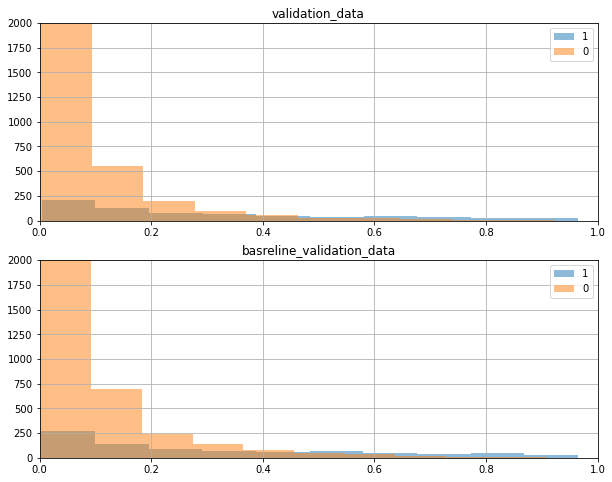

In [272]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))


fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.axis([0, 1, 0, 2000])

plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.axis([0, 1, 0, 2000])

plt.grid()
plt.legend()

## チューニング

In [26]:
import optuna

In [29]:
# 探索するパラメータ

params_base = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123,
}
random_state=123

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'num_leaves': trial.suggest_int('num_leaves',8,256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',5,200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(x_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
        cat_cols = ['facility_id', 'icu_id']
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        train_weight = compute_sample_weight(class_weight='balanced', y=y_tr).astype('float32')
    
        model = lgb.LGBMClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr, y_tr), (x_va, y_va)],
                  early_stopping_rounds=100,
                  verbose=0,
                  sample_weight = train_weight
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [30]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-03-27 08:10:52,385] A new study created in memory with name: no-name-6d507e69-96d2-4c1b-a0eb-d5eb0aa38957


[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597344848927815
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.792414358623587e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.792414358623587e-05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7756573845414456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756573845414456
[LightGBM] [Warning] bagging_fraction is set=0.8597344848927815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.859734484

[I 2023-03-27 08:12:12,219] Trial 0 finished with value: 0.881111394495306 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'reg_alpha': 0.492522233779106, 'reg_lambda': 83.76388146302445}. Best is trial 0 with value: 0.881111394495306.


[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248536920208
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015009027543233888, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015009027543233888
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6715890080754348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6715890080754348
[LightGBM] [Warning] bagging_fraction is set=0.8645248536920208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645248

[I 2023-03-27 08:12:56,070] Trial 1 finished with value: 0.9033858426149493 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'reg_alpha': 0.567922374174008, 'reg_lambda': 0.01732652966363563}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657756869209191
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3.52756635172055e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3.52756635172055e-05
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5877258780737462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5877258780737462
[LightGBM] [Warning] bagging_fraction is set=0.7657756869209191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.765775686

[I 2023-03-27 08:13:31,604] Trial 2 finished with value: 0.8843433513033084 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'reg_alpha': 1.3406343673102123, 'reg_lambda': 3.4482904089131434}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.8612216912851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8612216912851107
[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794569265892
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006808799287054756, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006808799287054756
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8612216912851107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8612216912851107
[LightGBM] [Warning] bagging_fraction is set=0.6614794569265892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6614794

[I 2023-03-27 08:14:09,266] Trial 3 finished with value: 0.8842266213801941 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 146, 'min_sum_hessian_in_leaf': 0.0006808799287054756, 'feature_fraction': 0.8612216912851107, 'bagging_fraction': 0.6614794569265892, 'reg_alpha': 0.2799978022399009, 'reg_lambda': 0.08185645330667264}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313816648219
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.889360449174926e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.889360449174926e-05
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7168505863397641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168505863397641
[LightGBM] [Warning] bagging_fraction is set=0.7154313816648219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7154313

[I 2023-03-27 08:14:42,903] Trial 4 finished with value: 0.8770422102729732 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 128, 'min_sum_hessian_in_leaf': 1.889360449174926e-05, 'feature_fraction': 0.7168505863397641, 'bagging_fraction': 0.7154313816648219, 'reg_alpha': 0.9434967110751797, 'reg_lambda': 0.5050346330980694}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509183379421682
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.004788147156768277, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.004788147156768277
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9720800091019398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9720800091019398
[LightGBM] [Warning] bagging_fraction is set=0.7509183379421682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75091833794

[I 2023-03-27 08:15:31,907] Trial 5 finished with value: 0.8778987276282181 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 88, 'min_sum_hessian_in_leaf': 0.004788147156768277, 'feature_fraction': 0.9720800091019398, 'bagging_fraction': 0.7509183379421682, 'reg_alpha': 3.1319282717196035, 'reg_lambda': 0.029005047452739414}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415171321313522
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.003971252247766701, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.003971252247766701
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6252276826982534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6252276826982534
[LightGBM] [Warning] bagging_fraction is set=0.7415171321313522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74151713213

[I 2023-03-27 08:16:24,251] Trial 6 finished with value: 0.8301758702735702 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 0.003971252247766701, 'feature_fraction': 0.6252276826982534, 'bagging_fraction': 0.7415171321313522, 'reg_alpha': 87.54657140659076, 'reg_lambda': 1.1965765212602313}. Best is trial 1 with value: 0.9033858426149493.


[LightGBM] [Warning] feature_fraction is set=0.8015300642054637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015300642054637
[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725340032332324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0030131614432849746, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0030131614432849746
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8015300642054637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8015300642054637
[LightGBM] [Warning] bagging_fraction is set=0.7725340032332324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.772534003

[I 2023-03-27 08:17:17,600] Trial 7 finished with value: 0.9035224235857501 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0030131614432849746, 'feature_fraction': 0.8015300642054637, 'bagging_fraction': 0.7725340032332324, 'reg_alpha': 0.23499322154972468, 'reg_lambda': 0.1646202117975735}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8346568914811361
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00423029374725911, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00423029374725911
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7552111687390055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552111687390055
[LightGBM] [Warning] bagging_fraction is set=0.8346568914811361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83465689148

[I 2023-03-27 08:17:53,432] Trial 8 finished with value: 0.8767498084351151 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 0.00423029374725911, 'feature_fraction': 0.7552111687390055, 'bagging_fraction': 0.8346568914811361, 'reg_alpha': 2.206714812711709, 'reg_lambda': 3.1594683442464033}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218331872684371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.7765808030254076e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.7765808030254076e-05
[LightGBM] [Warning] min_data_in_leaf is set=170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=170
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8818414207216692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8818414207216692
[LightGBM] [Warning] bagging_fraction is set=0.6218331872684371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.62183

[I 2023-03-27 08:18:30,038] Trial 9 finished with value: 0.8768086033257799 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 170, 'min_sum_hessian_in_leaf': 1.7765808030254076e-05, 'feature_fraction': 0.8818414207216692, 'bagging_fraction': 0.6218331872684371, 'reg_alpha': 0.05982625838323253, 'reg_lambda': 1.9490717640641542}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.5040305717020102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020102
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9940542446575642
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0010167214653943027, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0010167214653943027
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5040305717020102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5040305717020102
[LightGBM] [Warning] bagging_fraction is set=0.9940542446575642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99405424465

[I 2023-03-27 08:18:56,459] Trial 10 finished with value: 0.8473101602909165 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 0.0010167214653943027, 'feature_fraction': 0.5040305717020102, 'bagging_fraction': 0.9940542446575642, 'reg_alpha': 0.010612397212799423, 'reg_lambda': 0.1661409929489422}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.6893072883706839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6893072883706839
[LightGBM] [Warning] bagging_fraction is set=0.5643816257078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643816257078462
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0002546304993969339, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0002546304993969339
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6893072883706839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6893072883706839
[LightGBM] [Warning] bagging_fraction is set=0.5643816257078462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.564381625

[I 2023-03-27 08:22:12,364] Trial 11 finished with value: 0.9028212812451548 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 0.0002546304993969339, 'feature_fraction': 0.6893072883706839, 'bagging_fraction': 0.5643816257078462, 'reg_alpha': 0.10108607276304732, 'reg_lambda': 0.010211649165953098}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.8175314403750262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175314403750262
[LightGBM] [Warning] bagging_fraction is set=0.8626569725135499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8626569725135499
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.000153402164637483, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.000153402164637483
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8175314403750262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8175314403750262
[LightGBM] [Warning] bagging_fraction is set=0.8626569725135499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.86265697251

[I 2023-03-27 08:25:11,608] Trial 12 finished with value: 0.8963765711292914 and parameters: {'num_leaves': 255, 'min_data_in_leaf': 41, 'min_sum_hessian_in_leaf': 0.000153402164637483, 'feature_fraction': 0.8175314403750262, 'bagging_fraction': 0.8626569725135499, 'reg_alpha': 8.37591328058755, 'reg_lambda': 0.01045117234553353}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.6800062881915976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6800062881915976
[LightGBM] [Warning] bagging_fraction is set=0.5111428766066355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5111428766066355
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.008932219618102614, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.008932219618102614
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6800062881915976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6800062881915976
[LightGBM] [Warning] bagging_fraction is set=0.5111428766066355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.511142876

[I 2023-03-27 08:27:38,684] Trial 13 finished with value: 0.8689615751656204 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 190, 'min_sum_hessian_in_leaf': 0.008932219618102614, 'feature_fraction': 0.6800062881915976, 'bagging_fraction': 0.5111428766066355, 'reg_alpha': 0.17052736553266273, 'reg_lambda': 0.0988056140193565}. Best is trial 7 with value: 0.9035224235857501.


[LightGBM] [Warning] feature_fraction is set=0.8041563305513639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8041563305513639
[LightGBM] [Warning] bagging_fraction is set=0.9449350856793115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449350856793115
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00011414918234944389, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00011414918234944389
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8041563305513639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8041563305513639
[LightGBM] [Warning] bagging_fraction is set=0.9449350856793115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449350

[I 2023-03-27 08:30:09,640] Trial 14 finished with value: 0.9137250356014663 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 70, 'min_sum_hessian_in_leaf': 0.00011414918234944389, 'feature_fraction': 0.8041563305513639, 'bagging_fraction': 0.9449350856793115, 'reg_alpha': 0.045693362410957825, 'reg_lambda': 0.038934140387364174}. Best is trial 14 with value: 0.9137250356014663.


[LightGBM] [Warning] feature_fraction is set=0.798973943231285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.798973943231285
[LightGBM] [Warning] bagging_fraction is set=0.9883163331495053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883163331495053
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001215432268892957, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001215432268892957
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.798973943231285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.798973943231285
[LightGBM] [Warning] bagging_fraction is set=0.9883163331495053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988316333149505

[I 2023-03-27 08:31:17,831] Trial 15 finished with value: 0.9143091750480853 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 0.001215432268892957, 'feature_fraction': 0.798973943231285, 'bagging_fraction': 0.9883163331495053, 'reg_alpha': 0.03988616968038969, 'reg_lambda': 0.04384568349950474}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8974152759983636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974152759983636
[LightGBM] [Warning] bagging_fraction is set=0.9915442564871022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915442564871022
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0007547212191327465, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0007547212191327465
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8974152759983636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8974152759983636
[LightGBM] [Warning] bagging_fraction is set=0.9915442564871022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991544256

[I 2023-03-27 08:32:24,169] Trial 16 finished with value: 0.9105513853695867 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 65, 'min_sum_hessian_in_leaf': 0.0007547212191327465, 'feature_fraction': 0.8974152759983636, 'bagging_fraction': 0.9915442564871022, 'reg_alpha': 0.020436805378618597, 'reg_lambda': 0.03433559455816001}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8330744197268897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8330744197268897
[LightGBM] [Warning] bagging_fraction is set=0.9308943929336889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9308943929336889
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8.935790929091197e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8.935790929091197e-05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8330744197268897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8330744197268897
[LightGBM] [Warning] bagging_fraction is set=0.9308943929336889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.930894392

[I 2023-03-27 08:33:27,286] Trial 17 finished with value: 0.9135693330217827 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 51, 'min_sum_hessian_in_leaf': 8.935790929091197e-05, 'feature_fraction': 0.8330744197268897, 'bagging_fraction': 0.9308943929336889, 'reg_alpha': 0.04250632026048154, 'reg_lambda': 0.042677457059612324}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.7474499041095187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474499041095187
[LightGBM] [Warning] bagging_fraction is set=0.9422115556402889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422115556402889
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0004380338011497303, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0004380338011497303
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7474499041095187, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7474499041095187
[LightGBM] [Warning] bagging_fraction is set=0.9422115556402889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422115

[I 2023-03-27 08:34:23,871] Trial 18 finished with value: 0.9061118388312092 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 0.0004380338011497303, 'feature_fraction': 0.7474499041095187, 'bagging_fraction': 0.9422115556402889, 'reg_alpha': 0.029505797157008604, 'reg_lambda': 0.3613816693235936}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.9170263295138465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9170263295138465
[LightGBM] [Warning] bagging_fraction is set=0.9252732251354118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252732251354118
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0014854275432688256, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0014854275432688256
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9170263295138465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9170263295138465
[LightGBM] [Warning] bagging_fraction is set=0.9252732251354118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.925273225

[I 2023-03-27 08:35:26,251] Trial 19 finished with value: 0.9095580989969473 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 73, 'min_sum_hessian_in_leaf': 0.0014854275432688256, 'feature_fraction': 0.9170263295138465, 'bagging_fraction': 0.9252732251354118, 'reg_alpha': 0.010027969419668254, 'reg_lambda': 0.044612610488335765}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8309878210063437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8309878210063437
[LightGBM] [Warning] bagging_fraction is set=0.9921935443390247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9921935443390247
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0003715334734853126, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0003715334734853126
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8309878210063437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8309878210063437
[LightGBM] [Warning] bagging_fraction is set=0.9921935443390247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9921935

[I 2023-03-27 08:36:06,717] Trial 20 finished with value: 0.8284818206865326 and parameters: {'num_leaves': 8, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 0.0003715334734853126, 'feature_fraction': 0.8309878210063437, 'bagging_fraction': 0.9921935443390247, 'reg_alpha': 0.07760481503455585, 'reg_lambda': 0.023199708121192097}. Best is trial 15 with value: 0.9143091750480853.


[LightGBM] [Warning] feature_fraction is set=0.8091273410784455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091273410784455
[LightGBM] [Warning] bagging_fraction is set=0.9273977096274312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9273977096274312
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.893857790440731e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.893857790440731e-05
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8091273410784455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091273410784455
[LightGBM] [Warning] bagging_fraction is set=0.9273977096274312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.927397709

[I 2023-03-27 08:37:14,049] Trial 21 finished with value: 0.915029580032509 and parameters: {'num_leaves': 205, 'min_data_in_leaf': 45, 'min_sum_hessian_in_leaf': 6.893857790440731e-05, 'feature_fraction': 0.8091273410784455, 'bagging_fraction': 0.9273977096274312, 'reg_alpha': 0.04667317333314764, 'reg_lambda': 0.050582355537352366}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7995472472441396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7995472472441396
[LightGBM] [Warning] bagging_fraction is set=0.9104388655687001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9104388655687001
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7.391470668175935e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7.391470668175935e-05
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7995472472441396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7995472472441396
[LightGBM] [Warning] bagging_fraction is set=0.9104388655687001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910438865

[I 2023-03-27 08:38:41,768] Trial 22 finished with value: 0.9142896485324238 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 40, 'min_sum_hessian_in_leaf': 7.391470668175935e-05, 'feature_fraction': 0.7995472472441396, 'bagging_fraction': 0.9104388655687001, 'reg_alpha': 0.026721044041056047, 'reg_lambda': 0.07451032272050791}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7731462798990519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731462798990519
[LightGBM] [Warning] bagging_fraction is set=0.9006517574979365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006517574979365
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1.0257826229045205e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1.0257826229045205e-05
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7731462798990519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731462798990519
[LightGBM] [Warning] bagging_fraction is set=0.9006517574979365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9006517

[I 2023-03-27 08:39:42,581] Trial 23 finished with value: 0.9076305880471762 and parameters: {'num_leaves': 240, 'min_data_in_leaf': 35, 'min_sum_hessian_in_leaf': 1.0257826229045205e-05, 'feature_fraction': 0.7731462798990519, 'bagging_fraction': 0.9006517574979365, 'reg_alpha': 0.02312152610279702, 'reg_lambda': 0.07467868849739885}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.8554704582704863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8554704582704863
[LightGBM] [Warning] bagging_fraction is set=0.8157420611929699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8157420611929699
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.294576802299786e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.294576802299786e-05
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8554704582704863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8554704582704863
[LightGBM] [Warning] bagging_fraction is set=0.8157420611929699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.815742061

[I 2023-03-27 08:40:44,720] Trial 24 finished with value: 0.9112910438988101 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 6.294576802299786e-05, 'feature_fraction': 0.8554704582704863, 'bagging_fraction': 0.8157420611929699, 'reg_alpha': 0.1000586051654101, 'reg_lambda': 0.19997413091609148}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7373471207171156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7373471207171156
[LightGBM] [Warning] bagging_fraction is set=0.8967208581588109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967208581588109
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00027797661617380033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00027797661617380033
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7373471207171156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7373471207171156
[LightGBM] [Warning] bagging_fraction is set=0.8967208581588109, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967208

[I 2023-03-27 08:41:28,745] Trial 25 finished with value: 0.8993166690081501 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 0.00027797661617380033, 'feature_fraction': 0.7373471207171156, 'bagging_fraction': 0.8967208581588109, 'reg_alpha': 0.017634090175269762, 'reg_lambda': 0.055486302297669474}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.9359202818582051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359202818582051
[LightGBM] [Warning] bagging_fraction is set=0.9637477392254032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9637477392254032
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.356298381849394e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.356298381849394e-05
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9359202818582051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9359202818582051
[LightGBM] [Warning] bagging_fraction is set=0.9637477392254032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.963747739

[I 2023-03-27 08:42:40,161] Trial 26 finished with value: 0.9139977198440596 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 6.356298381849394e-05, 'feature_fraction': 0.9359202818582051, 'bagging_fraction': 0.9637477392254032, 'reg_alpha': 0.03150389776898005, 'reg_lambda': 0.09144538998867943}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7880733307854664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7880733307854664
[LightGBM] [Warning] bagging_fraction is set=0.8995181385779787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995181385779787
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00015169247729063443, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00015169247729063443
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7880733307854664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7880733307854664
[LightGBM] [Warning] bagging_fraction is set=0.8995181385779787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995181

[I 2023-03-27 08:43:39,462] Trial 27 finished with value: 0.9119336885836791 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 49, 'min_sum_hessian_in_leaf': 0.00015169247729063443, 'feature_fraction': 0.7880733307854664, 'bagging_fraction': 0.8995181385779787, 'reg_alpha': 0.12484292645725906, 'reg_lambda': 0.016607645835344912}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.8586951177330127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586951177330127
[LightGBM] [Warning] bagging_fraction is set=0.9538875680745383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538875680745383
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.00021981389524911843, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.00021981389524911843
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8586951177330127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8586951177330127
[LightGBM] [Warning] bagging_fraction is set=0.9538875680745383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538875

[I 2023-03-27 08:45:17,879] Trial 28 finished with value: 0.9118166705246548 and parameters: {'num_leaves': 235, 'min_data_in_leaf': 85, 'min_sum_hessian_in_leaf': 0.00021981389524911843, 'feature_fraction': 0.8586951177330127, 'bagging_fraction': 0.9538875680745383, 'reg_alpha': 0.05392514580590439, 'reg_lambda': 0.020621949248373524}. Best is trial 21 with value: 0.915029580032509.


[LightGBM] [Warning] feature_fraction is set=0.7777756551083584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7777756551083584
[LightGBM] [Warning] bagging_fraction is set=0.8182312770946693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182312770946693
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4.073757643365435e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4.073757643365435e-05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7777756551083584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7777756551083584
[LightGBM] [Warning] bagging_fraction is set=0.8182312770946693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.818231277

[I 2023-03-27 08:46:16,098] Trial 29 finished with value: 0.913102046335166 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.073757643365435e-05, 'feature_fraction': 0.7777756551083584, 'bagging_fraction': 0.8182312770946693, 'reg_alpha': 0.33236916530073274, 'reg_lambda': 0.34068251293058605}. Best is trial 21 with value: 0.915029580032509.


In [31]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.9150


{'num_leaves': 205,
 'min_data_in_leaf': 45,
 'min_sum_hessian_in_leaf': 6.893857790440731e-05,
 'feature_fraction': 0.8091273410784455,
 'bagging_fraction': 0.9273977096274312,
 'reg_alpha': 0.04667317333314764,
 'reg_lambda': 0.050582355537352366}

In [32]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 205,
 'min_data_in_leaf': 45,
 'min_sum_hessian_in_leaf': 6.893857790440731e-05,
 'feature_fraction': 0.8091273410784455,
 'bagging_fraction': 0.9273977096274312,
 'reg_alpha': 0.04667317333314764,
 'reg_lambda': 0.050582355537352366,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.02,
 'n_estimators': 100000,
 'bagging_freq': 1,
 'seed': 123}

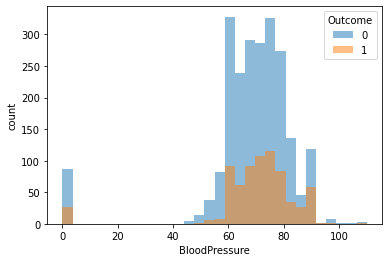

In [153]:
#　血圧との関係
plt.hist(train.loc[train['Outcome'] == 0, 'BloodPressure'].dropna(),
         bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Outcome'] == 1, 'BloodPressure'].dropna(),
         bins=30, alpha=0.5, label='1')
plt.xlabel('BloodPressure')
plt.ylabel('count')
plt.legend(title='Outcome')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   int64  
 10  BloodPressure_new         2887 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 257.9 KB
70.97859744990893
72.88277858176556
71.43436092829927
87
26


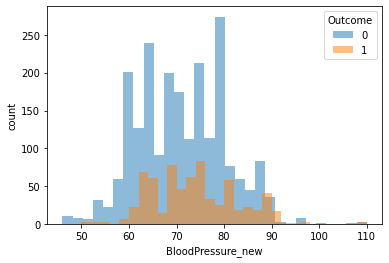

In [154]:
train['BloodPressure_new'] = train['BloodPressure'].replace([0], np.nan)
plt.hist(train.loc[train['Outcome'] == 0, 'BloodPressure_new'].dropna(),
         bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Outcome'] == 1, 'BloodPressure_new'].dropna(),
         bins=30, alpha=0.5, label='1')
plt.xlabel('BloodPressure_new')
plt.ylabel('count')
plt.legend(title='Outcome')

train.info()
BPmean_0= train.loc[train['Outcome'] == 0, 'BloodPressure_new'].mean()
print(BPmean_0)
BPmean_1= train.loc[train['Outcome'] == 1, 'BloodPressure_new'].mean()
print(BPmean_1)
BPmean= train['BloodPressure_new'].mean()
print(BPmean)

print(train[train['Outcome']==0]['BloodPressure_new'].isnull().sum(axis=0))
print(train[train['Outcome']==1]['BloodPressure_new'].isnull().sum(axis=0))

血圧0は欠損、欠損かどうかの特徴量作成(0なら1、取得された値があれば1)

## 欠損処理関数

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample= pd.read_csv("data/sample_submit.csv",header = None)

In [195]:
#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'Pregnancies_bin'
                ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [196]:
# 数値データ
col_num = X_train.columns[X_train.dtypes!='object'].values.tolist()

dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    X_train[col] = X_train[col].fillna(value_fillna)
    # 正規化
    value_min = X_train[col].min()
    value_max = X_train[col].max()
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    X_train[col] = (X_train[col] - value_min) / (value_max - value_min)
    # X_tarin[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_max    
    dict_num[col]['std'] = value_max    
    
print('Done')

DiabetesPedigreeFunction
BMI
Glucose
Age
Pregnancies
Done


In [197]:
# カテゴリデータ
# （embedding予定でラベルエンコーダー）
from sklearn.preprocessing import LabelEncoder
col_cat = X_train.columns[X_train.dtypes=='object'].values.tolist()

dict_cat = {}
for col in col_cat:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[col].fillna(value_fillna)
    
    X_train[col] = X_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(X_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    map_label = {j:i for i,j in enumerate(list_label)}
    X_train[col] = X_train[col].map(map_label)
    
    dict_cat[col] = {}
    dict_cat[col]['fillna'] = value_fillna
    dict_cat[col]['map_label'] = map_label
    dict_cat[col]['num_label'] = len(list_label)

print('Done')


Pregnancies_bin
Done


In [199]:
X_test

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,Pregnancies_bin
0,0.313823,0.708574,0.496403,0.000000,0.000000,2
1,0.027125,0.702316,0.223022,0.021739,0.230769,1
2,0.173992,0.557487,0.410072,0.000000,0.230769,1
3,0.166544,0.419302,0.640288,0.369565,0.076923,0
4,0.303618,0.712381,0.474820,0.152174,0.076923,0
...,...,...,...,...,...,...
1995,0.013546,0.693011,0.669065,0.108696,0.307692,1
1996,0.168592,0.676110,0.690647,0.152174,0.461538,3
1997,0.270176,0.962270,0.352518,0.173913,0.538462,3
1998,0.079172,0.712423,0.316547,0.108696,0.153846,0


In [200]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DiabetesPedigreeFunction  3000 non-null   float64
 1   BMI                       3000 non-null   float64
 2   Glucose                   3000 non-null   float64
 3   Age                       3000 non-null   float64
 4   Pregnancies               3000 non-null   float64
 5   Pregnancies_bin           3000 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.8 KB


In [173]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(X_train['Pregnancies_bin'].values.reshape(-1, 1))
list_ohe_label = sorted(list(set(le.classes_) | set(['unknown'])))
map_ohe_label = {j:i for i,j in enumerate(list_label)}

map_label

{'-1': 0, '-3': 1, '0': 2, '3-': 3, 'unknown': 4}